In [1]:
%run center_of_mass_calculation.ipynb

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [5]:
B = 1
N = 50
I = 18
V = 52
mu = 2.08
S = 0.015

In [44]:
def rotation_matrix(t, omega, i):
    return np.array([
        [np.cos(omega*t + (np.pi/2) + (2*np.pi*(i-1))/(3)), np.sin(omega*t + (np.pi/2) + (2*np.pi*(i-1))/(3))],
        [-np.sin(omega*t + (np.pi/2) + (2*np.pi*(i-1))/(3)), np.cos(omega*t + (np.pi/2) + (2*np.pi*(i-1))/(3))],
    ])

In [45]:
def delta(omega, t, i):
    value = omega*t + np.pi/2 + ((i - 1)*4*np.pi/6)
    return ((-np.pi*6 <= value) & (value <= 7*np.pi/6)).astype(int)

In [46]:
def torque(t, omega, r, m):
    return (-B*N*I*mu*S*(
        delta(omega, t, 1)*np.sin(omega*t + np.pi/2)
        + delta(omega, t, 2)*np.sin(omega*t + 7*np.pi/6)
        + delta(omega, t, 3)*np.sin(omega*t + 11*np.pi/6)
    # ) - 10*r[0]*m*(np.cos(omega*t + np.pi/2) + np.cos(omega*t + 7*np.pi/6) + np.cos(omega*t + 11*np.pi/6)))
    ) - 10*m*(
        (r[0]*np.cos(omega*t + np.pi/2) + r[1]*np.sin(omega*t + np.pi/2))
        + (r[0]*np.cos(omega*t + 7*np.pi/6) + r[1]*np.sin(omega*t + 7*np.pi/6))
        + (r[0]*np.cos(omega*t + 11*np.pi/6) + r[1]*np.sin(omega*t + 11*np.pi/6))
    ))

In [47]:
def domega_dt(t, omega, r, m):
    r1 = tf.tensordot(tf.constant(rotation_matrix(t, omega, 1), dtype="float32"), r, axes=[[1], [0]])
    r2 = tf.tensordot(tf.constant(rotation_matrix(t, omega, 2), dtype="float32"), r, axes=[[1], [0]])
    r3 = tf.tensordot(tf.constant(rotation_matrix(t, omega, 3), dtype="float32"), r, axes=[[1], [0]])
    r1_dot = tf.reduce_sum(tf.square(r1))
    r2_dot = tf.reduce_sum(tf.square(r2))
    r3_dot = tf.reduce_sum(tf.square(r3))
    return torque(t, omega, r, m)/(m*(r1_dot + r2_dot + r3_dot))

In [48]:
def evaluate_efficiency(parameters, t, show_plots=False):
    r, m = calculate_center_of_mass(parameters)
    omega = solve_ivp(domega_dt, [0, 120], np.array([0]), args=tuple([r, m]), t_eval=t).y[0]
    
    if show_plots:
        plt.figure(figsize=(7, 7))
        plt.title("Залежність моменту обертання двигуна від часу")
        plt.xlabel("Час (секунди)")
        plt.ylabel("Момент обертання (Н * м)")
        plt.grid()
        plt.plot(t, -torque(t, omega, r, m))

        plt.figure(figsize=(7, 7))
        plt.title("Залежність швидкості обертання від часу")
        plt.xlabel("Час (секунди)")
        plt.ylabel("Швидкість обертання (об./хв)")
        plt.grid()
        plt.plot(t, -(omega/2*np.pi)*60)
    
    power = omega*torque(t, omega, r, m)
    efficiency = power / (I * V)
    
    return tf.reduce_max(efficiency)

In [49]:
t = np.linspace(0, 120, 1000)

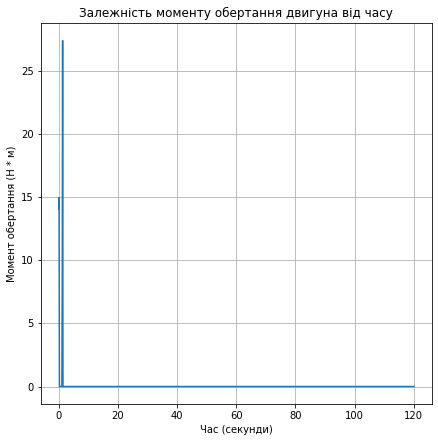

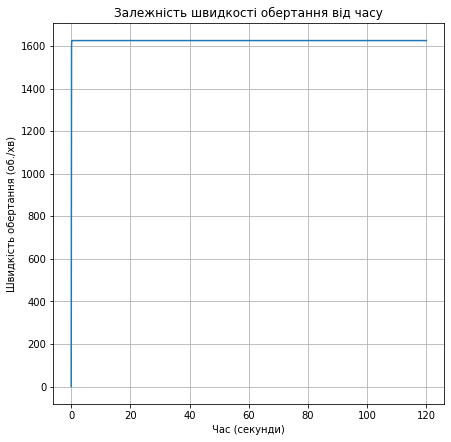

In [50]:
# efficiency = evaluate_efficiency(canonical_parameters, t, show_plots=True)

In [51]:
# efficiency

<tf.Tensor: shape=(), dtype=float32, numpy=0.5056526>